In [1]:
from lifelines import CoxPHFitter
import pandas as pd

In [2]:
df=pd.read_csv('tele_churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [5]:
## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)


## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.



C:\Users\Arth\AppData\Local\Temp\ipykernel_24608\141051467.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)


In [6]:
durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

In [7]:
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data 

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [8]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True, dtype=int)
df_dummy.head(100)

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,12,1,78.95,0,0,0,0,1,0,0
96,71,0,66.85,0,1,1,1,1,0,0
97,5,1,21.05,0,1,0,0,1,1,0
98,52,0,21.00,0,1,0,0,1,1,0


In [9]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2025-01-31 08:03:15 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
MonthlyCharges                  -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
SeniorCitizen                    0.40      1.49      0.06            0.29            0.50                1.33                1.66
gender_Male                     -0.01      0.99      0.05           -0.10            0.08                0.90                1.08
Partner_Yes                     -0.81      0.45      0.05           -0.92           -0.70                0.40                0.50
Dependents_Yes                  -0.36      0.70      0.07           -0.49           -0.22                0.61                0.80
PhoneService_Yes                 0.69      2.00      0.10            0.49            0.90                1.63                2.45
StreamingTV_No internet service -2.10      0.12      0.13           -2.36           -1.84                0.09                0.16
StreamingTV_Yes                 -0.19      0.83      0.06           -0.31           -0.07                0.73                0.93

                                 cmp to      z      p  -log2(p)
covariate                                                      
MonthlyCharges                     0.00  -6.13 <0.005     30.06
SeniorCitizen                      0.00   7.16 <0.005     40.15
gender_Male                        0.00  -0.23   0.82      0.29
Partner_Yes                        0.00 -14.93 <0.005    164.98
Dependents_Yes                     0.00  -5.21 <0.005     22.37
PhoneService_Yes                   0.00   6.65 <0.005     34.96
StreamingTV_No internet service    0.00 -15.79 <0.005    184.09
StreamingTV_Yes                    0.00  -3.10 <0.005      9.03
---
Concordance = 0.71
Partial AIC = 30380.78
log-likelihood ratio test = 941.30 on 8 df
-log2(p) of ll-ratio test = 654.95

<Axes: xlabel='log(HR) (95% CI)'>

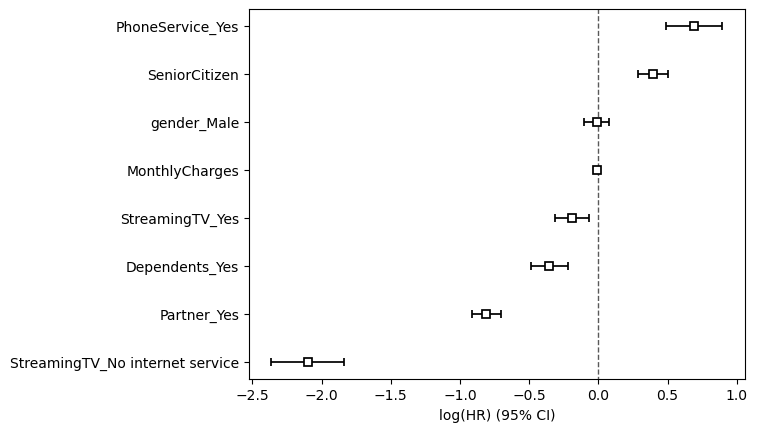

In [10]:
cph.plot()

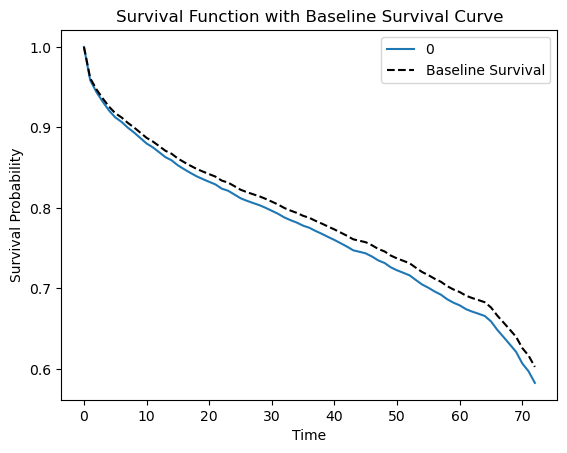

In [47]:
data_1= {
    'tenure': [1],
    'MonthlyCharges': [29.85],                       #Non-Churn Data
    'SeniorCitizen': [0],
    'gender_Male': [0],
    'Partner_Yes': [1],
    'Dependents_Yes': [0],
    'PhoneService_Yes': [0],
    'StreamingTV_No internet service': [0],
    'StreamingTV_Yes': [0],
}


#Churn
data_2= {
    'tenure': [25],
    'MonthlyCharges': [98.50],
    'SeniorCitizen': [1],                                                
    'gender_Male': [0],
    'Partner_Yes': [1],                                    
    'Dependents_Yes': [0],
    'PhoneService_Yes': [1],
    'StreamingTV_No internet service': [0],
    'StreamingTV_Yes': [1],
}

original_df = pd.DataFrame(data_2)
#print(original_df.head())
data= cph.predict_survival_function(original_df).plot(label= "Predicted")

import matplotlib.pyplot as plt
baseline_survival = cph.baseline_survival_
plt.plot(baseline_survival.index, baseline_survival.values, label='Baseline Survival', color='black', linestyle='--')
# Add a legend and labels
plt.legend()
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Function with Baseline Survival Curve')
plt.show()

In [50]:
# Predictions and analysis functions
def predict_cumulative_hazard(X, times):
    return cph.predict_cumulative_hazard(X, times=times)

def predict_expectation(X):
    return cph.predict_expectation(X)

def predict_log_partial_hazard(X):
    return cph.predict_log_partial_hazard(X)

def predict_partial_hazard(X):
    return cph.predict_partial_hazard(X)

def predict_median(X):
    return cph.predict_median(X)

def predict_percentile(X, p):
    return cph.predict_percentile(X, p)

def predict_survival_function(X, times):
    return cph.predict_survival_function(X, times=times)

def score_model(df):
    return cph.score(df)

# Example usage with reference data and specific times
times = [10, 20, 30, 40]

print("Cumulative Hazard:\n", predict_cumulative_hazard(original_df, times))
print("Expected Time:\n", predict_expectation(original_df))
print("Log Partial Hazard:\n", predict_log_partial_hazard(original_df))
print("Partial Hazard:\n", predict_partial_hazard(original_df))
print("Median Time:\n", predict_median(original_df))
print("25th Percentile Time:\n", predict_percentile(original_df, 0.25))
print("Survival Function:\n", predict_survival_function(original_df, times))
#print("Model Score:\n", score_model(df_dummy))

Cumulative Hazard:
              0
10.0  0.127794
20.0  0.183476
30.0  0.227634
40.0  0.274246
Expected Time:
 0    55.794128
dtype: float64
Log Partial Hazard:
 0    0.064224
dtype: float64
Partial Hazard:
 0    1.066331
dtype: float64
Median Time:
 inf
25th Percentile Time:
 inf
Survival Function:
              0
10.0  0.880035
20.0  0.832372
30.0  0.796416
40.0  0.760145


In [46]:
# Input parameters (example values)
cumulative_hazard = 0.274246  # From cumulative hazard table (at a specific time, e.g., 40)
partial_hazard = 1.066331     # From Partial Hazard
survival_probability = 0.76   # From Survival Function (at the same time, e.g., 40)
expected_time = 55.794128     # From Expected Time

# Risk evaluation logic
if cumulative_hazard > 0.3 or partial_hazard > 1.5 or survival_probability < 0.5:
    risk_level = "High Risk of Churn"
elif 0.1 < cumulative_hazard <= 0.3 or 1.0 < partial_hazard <= 1.5 or 0.5 <= survival_probability < 0.7:
    risk_level = "Moderate Risk of Churn"
else:
    risk_level = "Low Risk of Churn"

# Print results
print("Churn Analysis:")
print(f"- Cumulative Hazard: {cumulative_hazard}")
print(f"- Partial Hazard: {partial_hazard}")
print(f"- Survival Probability: {survival_probability}")
print(f"- Expected Time: {expected_time:.2f}")
print(f"- Risk Level: {risk_level}")


Churn Analysis:
- Cumulative Hazard: 0.274246
- Partial Hazard: 1.066331
- Survival Probability: 0.76
- Expected Time: 55.79
- Risk Level: Moderate Risk of Churn


In [49]:
concordance_index = cph.concordance_index_
print(concordance_index)

0.7108933879138637
